In [1]:
import boto3
import io
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-colorblind')

## Note

Data Sources: 
- PFMC Inf Jan 2022 to June 2022
- PFMC Events Apr 2022 to Sep 2022
- ECIW Subject Jan 2022 to June 2022

Target Variable: 
- Lapse and Surrender

Objective:
- To project lapse events that are likely to occur 3 months ahead

Filters
- Keep only "Alive", deceased_ind !=2
- Remove zero base face amount
- Remove policies with negative policy_age

Features:

-	Policy age
-	Modified cash value:  total cash value – total loan prin if loan exists
-	Modified payment: modal premium (periodic payment) + interest due
-	Difference between cash value and payment
-	Cash value normalized by face amount
-   Actual Payment - Target Payment
-	Prem mode change flag
-   Number of times being current in the past x month
-   Number of times being lapse in the past x month
-   Number of times being reinstated in the past x month

### PFMC

In [2]:
pfmc =  pd.read_parquet('pfmc_jan_june.parquet') 

In [3]:
pfmc[pfmc['agmt_pkge_id']=='990967950000']

,year,month,agmt_pkge_id,vul,ul,term,aos_status_code,val_inforce_cls,kind_code,sub_kind,...,reinstate_ind_lag1,reinstate_ind_lag2,reinstate_ind_lag3,surrender_ind_lag1,surrender_ind_lag2,surrender_ind_lag3,cur_status,prior_1mo_status,prior_2mo_status,prior_3mo_status
506883,2022,1,990967950000,YES,NaN,NaN,B,PP,01469,B,...,0.0,0.0,0.0,0.0,0.0,0.0,surrender,current,current,current
1129979,2022,2,990967950000,YES,NaN,NaN,B,PP,01469,B,...,0.0,0.0,0.0,1.0,0.0,0.0,current,surrender,current,current
2205096,2022,3,990967950000,YES,NaN,NaN,B,PP,01469,B,...,0.0,0.0,0.0,0.0,1.0,0.0,reinstated,current,surrender,current
4365208,2022,6,990967950000,YES,NaN,NaN,B,PP,01469,B,...,1.0,0.0,0.0,0.0,0.0,1.0,current,reinstated,current,surrender


### ECIW

In [3]:
eciw =  pd.read_parquet('eciw_jan_june.parquet') 

In [4]:
eciw['as_of_hist_dt']= eciw['as_of_hist_dt'].astype('datetime64[ns]')
eciw['eciw_cur_month'] = eciw['as_of_hist_dt'].astype('datetime64[ns]').map(lambda x: x.strftime('%Y-%m'))
eciw['eciw_prev_month'] =  ((eciw['as_of_hist_dt'] - pd.DateOffset(months=1)).dt.to_period("M")).astype(str)

### Merge

In [5]:
df=pfmc.merge(eciw, how='left', 
              left_on=['agmt_pkge_id','pfmc_cur_month'], 
              right_on = ['agmt_pkge_id','eciw_cur_month'],
              suffixes=('', '_remove'))
df.drop([i for i in df.columns if 'remove' in i],axis=1, inplace=True)

In [6]:
del pfmc, eciw

In [7]:
print(df.shape)

(4996669, 288)


In [8]:
df.head()

,year,month,agmt_pkge_id,vul,ul,term,aos_status_code,val_inforce_cls,kind_code,sub_kind,...,hhld_qdrnt_cd,wc_tot_asset_amt,wc_asset_mix_anty_amt,wc_asset_mix_bond_amt,wc_asset_mix_dep_amt,wc_asset_mix_mf_amt,wc_asset_mix_oth_asset_amt,wc_asset_mix_stk_amt,eciw_cur_month,eciw_prev_month
0,2022,1,966027580000,YES,NaN,NaN,B,PP,01479,B,...,4.0,997748.0,25350.0,46806.0,240789.0,414293.0,71455.0,199055.0,2022-01,2021-12
1,2022,1,R31350050000,YES,NaN,NaN,B,PP,01134,B,...,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-01,2021-12
2,2022,1,V24761960000,YES,NaN,NaN,A,PP,CVL13,B,...,7.0,377747.0,3181.0,2487.0,118083.0,90071.0,9834.0,154091.0,2022-01,2021-12
3,2022,1,V27455840000,YES,NaN,NaN,A,PP,CVPR17,A,...,1.0,1331384.0,48988.0,37915.0,188763.0,514359.0,31633.0,509726.0,2022-01,2021-12
4,2022,1,997005030000,YES,NaN,NaN,B,PP,01471,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01,2021-12


#### status

In [10]:
# pd.set_option('display.max_rows', None) 
# df.agg(['count', 'nunique', 'min', 'max']).transpose()

In [9]:
# change status names
df['3mo_ahead_status'] = df['cur_status']
df['current_status'] = df['prior_3mo_status']

### Target Variable

In [10]:
df['3mo_ahead_Lapse'] = (np.where((df['3mo_ahead_status']=='lapse') | ((df['3mo_ahead_status']=='surrender')), 1,0))
df['current_lapse_status'] = (np.where((df['current_status']=='lapse') | ((df['current_status']=='surrender')), 1,0))

### Data Filters

In [12]:
df = df[(df['deceased_ind']!=2)]

##### age of policy holder

In [13]:
df['holder_age'] = df['attained_age']
print(min(df['holder_age']))
print(max(df['holder_age']))

0
111


##### policy age

In [14]:
df['policy_age'] = np.round((df['val_dt'] -df['issue_dt'].astype('datetime64[ns]'))/np.timedelta64(1, 'M'), 0).astype(int)
print(min(df['policy_age']))
print(max(df['policy_age']))

-11
677


In [15]:
# remove decseased  (2 = deceased)
#df= df[df['deceasead_ind']!=2]

# remove policies with zero base face amount 
df = df[df['base_face_amt']!=0]

# remove negative policies with negative policy age
df = df[df['policy_age']>=0]

In [16]:
# dropping unique or null columns
cols_to_drop = ['ul',
'term',
'lp_cntr_cd',
'lp_cntr_rsn_cd',
'lp_bill_cd',
'lp_bill_rsn_cd',
'lp_bnf_stat_cd',
'lp_bnf_rsn_cd',
'lp_canc_rsn_cd',
'issue_age_2nd',
'extra_ratings_2nd',
'imp_rating_2nd',
'occ_rating_2nd',
'smoking_habit_2nd',
'pref_rating_2nd',
'select_rating_2nd',
'gender_2nd',
'undw_class_2nd',
'reinstmt_dt',
'end_dt',
'year',
'vul',
'series',
'debit_indicator',
'rptg_country',
'closed_block_stat',
'wsc_ind',
'policy_part',
'cvrg_typ',
'prod_type',
'ins_nature_cd',
'has_sps_ind',
'has_chld_ind',
'db_pattern_cd',
'liv_num',
'frst_scnd_dth_ind',
'lim_prem_sig_ind',
'term_cvrg_sig_ind',
'prem_pay_dur',
'prem_pay_age_num',
'cvrg_dur',
'cvrg_age_num',
'conv_sig_ind',
'conv_dur',
'conv_age_num',
'ins_type_code',
'trad_intsens_code',
'conv_pct',
'lvl_prem_prd_num',
'enhnc_comp_ind',
'sngl_pay_ind',
'lvl_prem_prd_age',
'nature',
'pref_rating',
'select_rating',
'aip_face_amt',
'pua_face_amt',
'puar_face_amt',
'oyt_face_amt',
'designer_face_amt',
'rdr4_face_amt',
'mpt_502',
'grs_ropt_rdrprem_pd',
'base_pol_count',
'major_lob',
'ttr_feature',
'min_cntrct_fund',
'holding_co_cd',
'rdr_term_ill_ind',
'base_fam_spo_ind',
'base_fam_child_ind',
'adb_spo_base_ind',
'extc_ind',
'rdr_oyt_dsgn_ind',
'rdr_paidup_inc_dsgn_ind',
'oyt_ind',
'pua_base_pri_ind',
'pua_base_spo_ind',
'pua_rdr_ind',
'wp_rdr_child_ind',
'wp_rdr_sps_ind',
'rdr_est_prot_ind',
'attained_age_2nd',
'enhanced_val',
'mpt_11',
'prod_line_desc',
'prod_desc',
'acord_prod_typ_cd',
'acord_prod_typ_desc',
'limra_lob_desc',
'prior_3mo_status',
'cur_status'
]

df = df[df.columns.drop(cols_to_drop)]

#### Processing

In [17]:
df['issue_year']=  df['issue_dt'].astype('datetime64[ns]').dt.year

### Features

In [19]:
### more features
# number of times current/lapse/reinstate, in the past x months
# normalized by face amount 
# actual payment vs. target, past x month
# customer segmentation: demographic info 
# customer always pay before/on due date, x day past due dates? 

In [20]:
# 'diff_mod_bld_value'
# 'mpt_total_bld_face_amt'
# 'accum_actual_prem_paid_lag3_change'
# 'modal_prem_bld_lag3_change'
# 'diff_act_pmt_target_pmt_2'

#### cash value related

In [18]:
df['mod_mpt_total'] = df['mpt_tot_act_val'] - df['tot_loan_prncpl']
df['mod_mpt3'] = df['mpt_3'] - df['tot_loan_prncpl']
df['mod_mpt4'] = df['mpt_4'] - df['tot_loan_prncpl']

##### payment related

In [19]:
df['mod_bld_payment'] = df['modal_prem_bld'] + df['unpd_loan_int_due']
df['mod_sch_payment'] = df['modal_prem_sch'] + df['unpd_loan_int_due']

#### (cash value - payment)

In [20]:
df['diff_mod_bld_value'] = df['mod_mpt_total'] - df['mod_bld_payment']
df['diff_mod_sch_value'] = df['mod_mpt_total'] - df['mod_sch_payment']

##### Normalized cash value (by base face amt)

In [21]:
df['mpt_total_bld_face_amt'] = df['mod_mpt_total']/df['base_face_amt']
df['mpt3_bld_face_amt'] = df['mod_mpt3']/df['base_face_amt']
df['mpt4_bld_face_amt'] = df['mod_mpt4']/df['base_face_amt']

df['mpt_total_sch_face_amt'] = df['mod_mpt_total']/df['base_face_amt']
df['mpt3_sch_face_amt'] = df['mod_mpt3']/df['base_face_amt']
df['mpt4_sch_face_amt'] = df['mod_mpt4']/df['base_face_amt']

In [25]:
# df.replace(np.inf, 0, inplace=True)

##### Actual Payment vs. Target Payment (3month window)

In [22]:
df['accum_actual_prem_paid_lag3'] = df.groupby(['policy_id'])['accum_actual_prem_paid'].shift(3)
df['accum_actual_prem_paid_lag3_change'] = df['accum_actual_prem_paid'] -df['accum_actual_prem_paid_lag3'] 

In [23]:
df['modal_prem_bld_lag3'] = df.groupby(['policy_id'])['modal_prem_bld'].shift(3)
df['modal_prem_bld_lag3_change'] = df['modal_prem_bld'] -df['modal_prem_bld_lag3'] 

In [24]:
df['diff_act_pmt_target_pmt_1'] = df['accum_actual_prem_paid_lag3_change'] - df['modal_prem_bld']
df['diff_act_pmt_target_pmt_2'] = df['accum_actual_prem_paid_lag3_change'] - df['modal_prem_bld_lag3']
df['diff_act_pmt_target_pmt_3'] = df['accum_actual_prem_paid_lag3_change'] - df['modal_prem_bld_lag3_change']

##### MoM Change in prem mode

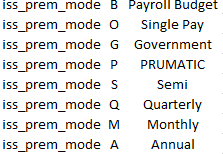

In [25]:
df['prem_mode_lag1'] = df.groupby(['policy_id'])['prem_mode'].shift(1)
df['prem_mode_lag1'] = np.where(df['prem_mode_lag1'].isnull(), df['prem_mode'], df['prem_mode_lag1'])
df['prem_mode_change_flag']= np.where((df['prem_mode_lag1'] !=df['prem_mode']), 1,0)

In [26]:
df[df['agmt_pkge_id']=='V27647760000'][['policy_id', 'month','current_status', 'prem_mode', 'prem_mode_change_flag']]

,policy_id,month,current_status,prem_mode,prem_mode_change_flag
2450401,V2764776,3,current,P,0
2626797,V2764776,4,current,P,0
4030948,V2764776,5,current,P,0
4207607,V2764776,6,current,P,0


In [31]:
#V24761960000
pd.set_option('display.max_columns', None)
df[df['agmt_pkge_id']=='V20012960000'][['policy_id', 'pfmc_cur_month', 'current_status',  '3mo_ahead_status',
                                        'prem_mode',  'prem_mode_change_flag',
                                        'base_face_amt',
                                        'accum_actual_prem_paid', 
                                        'accum_actual_prem_paid_lag3', 
                                        'accum_actual_prem_paid_lag3_change',
                                        'annlzd_bld_prem',
                                        'modal_prem_bld', 
                                        'modal_prem_bld_lag3', 
                                        'modal_prem_bld_lag3_change',
                                        'diff_act_pmt_target_pmt_1',
                                       'diff_act_pmt_target_pmt_2',
                                        'diff_act_pmt_target_pmt_3'
                                      ]]

,policy_id,pfmc_cur_month,current_status,3mo_ahead_status,prem_mode,prem_mode_change_flag,base_face_amt,accum_actual_prem_paid,accum_actual_prem_paid_lag3,accum_actual_prem_paid_lag3_change,annlzd_bld_prem,modal_prem_bld,modal_prem_bld_lag3,modal_prem_bld_lag3_change,diff_act_pmt_target_pmt_1,diff_act_pmt_target_pmt_2,diff_act_pmt_target_pmt_3
636580,V2001296,2022-01,current,current,A,0,75000.0,4995.96,NaN,NaN,346.86,0.0,NaN,NaN,NaN,NaN,NaN
834568,V2001296,2022-02,current,current,P,1,75000.0,4995.96,NaN,NaN,372.00,31.0,NaN,NaN,NaN,NaN,NaN
2460283,V2001296,2022-03,current,current,P,0,75000.0,5026.96,NaN,NaN,372.00,31.0,NaN,NaN,NaN,NaN,NaN
2614614,V2001296,2022-04,current,current,P,0,75000.0,5057.96,4995.96,62.0,372.00,31.0,0.0,31.0,31.0,62.0,31.0
4016159,V2001296,2022-05,current,current,P,0,75000.0,5088.96,4995.96,93.0,372.00,31.0,31.0,0.0,62.0,62.0,93.0
4226414,V2001296,2022-06,current,current,P,0,75000.0,5119.96,5026.96,93.0,372.00,31.0,31.0,0.0,62.0,62.0,93.0


#### (household AUM - Cash Value)

In [28]:
df['diff_household_asset_cash_val'] = df['wc_tot_asset_amt']  - df['mod_mpt_total']

In [29]:
df['hh_stock_mix'] = df['wc_asset_mix_stk_amt']/df['wc_tot_asset_amt'] 

In [30]:
df['hh_bond_mix'] = df['wc_asset_mix_bond_amt']/df['wc_tot_asset_amt'] 

In [31]:
df['hh_bond_ann_flag'] = np.where(df['wc_asset_mix_anty_amt']>df['wc_asset_mix_bond_amt'],1,0)

In [32]:
df['hh_annuity_mix'] = df['wc_asset_mix_anty_amt']/df['wc_tot_asset_amt'] 

In [37]:
df['hh_mult_over_sub']= df['wc_tot_asset_amt']/df['subj_aum_amt']

##### (Subject AUM - Cash Value)

In [38]:
df['diff_aum_cash_val'] = df['subj_aum_amt']  - df['mod_mpt_total']

##### Num of status past 3month

In [39]:
df['current'] = df['current_status'].map(lambda x: 1 if x == 'current' else 0)
df['lapse'] = df['current_status'].map(lambda x: 1 if x == 'lapse' else 0)
df['reinstate'] = df['current_status'].map(lambda x: 1 if x == 'reinstated' else 0)

In [40]:
df['num_current_3m'] = df.groupby('policy_id')['current'].transform(lambda x: x.rolling(3).sum())

In [41]:
df['num_lapse_3m'] = df.groupby('policy_id')['lapse'].transform(lambda x: x.rolling(3).sum())

In [42]:
df['num_reinstate_3m'] = df.groupby('policy_id')['reinstate'].transform(lambda x: x.rolling(3).sum())

In [43]:
# backward fill
df['num_current_3m']=df['num_current_3m'].bfill()
df['num_reinstate_3m']=df['num_reinstate_3m'].bfill()
df['num_lapse_3m']=df['num_lapse_3m'].bfill()

In [38]:
df[df['agmt_pkge_id']=='V26935570000'][['policy_id', 'month', 'current_status','3mo_ahead_status',
                                        'current', 'lapse', 'reinstate',
                                        'num_current_3m','num_reinstate_3m','num_lapse_3m']]

,policy_id,month,current_status,3mo_ahead_status,current,lapse,reinstate,num_current_3m,num_reinstate_3m,num_lapse_3m
90965,V2693557,1,current,lapse,1,0,0,3.0,0.0,0.0
1562222,V2693557,2,current,reinstated,1,0,0,3.0,0.0,0.0
1802337,V2693557,3,current,current,1,0,0,3.0,0.0,0.0
3368857,V2693557,5,lapse,current,0,1,0,2.0,0.0,1.0
4821232,V2693557,6,reinstated,current,0,0,1,1.0,1.0,1.0


In [39]:
# df[(df['lapse']==1)&(df['month']==5)].head()

In [40]:
# df[df['agmt_pkge_id']=='V27647760000'][['prem_mode','prem_mode_lag1', 'prem_mode_change_flag' ]]

#### months since status

In [41]:
# df['monthsinceclapse']=

#### more features

In [44]:
df['rest_mpt'] = df['mpt_10']+df['mpt_600']+df['mpt_620']+df['mpt_1600']+df['mpt_20881']

In [45]:
df['rdr_face_amt'] = df['rdr1_face_amt']+df['rdr2_face_amt']+df['rdr3_face_amt']

In [46]:
df['retain_trgt_7'] = df['rtain_amt']-df['trgt_7_pay']

In [47]:
df['policy_age_trgt7']=df['policy_age']/12*df['trgt_7_pay']

In [48]:
df['policy_age_sq']=df['policy_age']/12*df['policy_age']

In [49]:
df['holder_age_cash']=df['holder_age']*df['mod_mpt_total']
df['policy_age_cash']=df['policy_age']/12*df['mod_mpt_total']
df['issue_age_cash']=df['issue_age']*df['mod_mpt_total']

In [50]:
df['diff_policy_issue_issue']=df['policy_age_cash']-df['issue_age_cash']

In [51]:
df['diff_cash_holder_issue']=df['holder_age_cash']-df['issue_age_cash']

#### Buckets

In [52]:
#age bucket
col         = 'holder_age'  
conditions  = [(df[col] <= 20), (df[col] >20) & (df[col] <= 30),  
               (df[col] >30) & (df[col] <= 35),  (df[col] >35) & (df[col] <= 40), 
               (df[col] >40) & (df[col] <= 45), (df[col] >45) & (df[col] <= 50),  
               (df[col] >50) & (df[col] <= 55), (df[col] >55) & (df[col] <= 60), 
               (df[col] >60) & (df[col] <= 65), (df[col] >65) & (df[col] <= 70), 
               (df[col] >70) & (df[col] <= 75), (df[col] >75) & (df[col] <= 80), 
               (df[col] >80) & (df[col] <= 85), df[col] >85]  
              
choices     = [ '1. <20', '2. (20,30]', '3. (30,35]', '4. (35,40]', '5. (40,45]', '6. (45,50]',
               '7. (50,55]', '8. (55,60]', '9. (60,65]', '10. (65,70]', '11. (70,75]','12. (75,80]', 
               '13. (80,85]','14. >85']
    
df["holder_age_bucket"] = np.select(conditions, choices, default='missing')

In [53]:
#cash value
col         = 'mod_mpt_total'  
conditions  = [(df[col] >=0) & (df[col] <= 10000),
               (df[col] >10000) & (df[col] <= 25000),
               (df[col] >25000) & (df[col] <= 50000),
               (df[col] >50000) & (df[col] <= 100000),  
               (df[col] >100000) & (df[col] <= 250000),  
               (df[col] >250000) & (df[col] <= 500000),  
               (df[col] >500000) & (df[col] <= 750000), 
               (df[col] >750000) & (df[col] <= 1000000),
               (df[col] >1000000) & (df[col] <= 3000000),
               (df[col] >3000000) & (df[col] <= 5000000), 
               (df[col] > 5000000)]  
              
choices     = [ '1. $0k-10k', '2. $10k-25k', '3. $25k-50k','4. $50k-100k', 
               '5. $100k-250k', '6. $250k-500k','7. $500k-750k', '8. $750k-1M', 
               '9. $1M-3M', '10. $3M-5M','11. >$5M']
    
df["cash_val_bucket"] = np.select(conditions, choices, default='missing')

In [54]:
# cohort
col         = 'issue_year'  
conditions  = [(df[col] <= 1992), 
               (df[col] > 1992) & (df[col] <= 2000),  
               (df[col] > 2000) & (df[col] <= 2010),  
               (df[col] > 2010)]  
              
choices     = [ '< 1992', '1992-2000', '2001-2010', '2011 to 2022']
    
df["issue_yr_cohort"] = np.select(conditions, choices, default='missing')

In [53]:
# # cohort
# col         = 'issue_year'  
# conditions  = [(df[col] <= 1992), 
#                (df[col] > 1992) ]  
              
# choices     = [ '< 1992', '>= 1992']
    
# df["issue_yr_cohort"] = np.select(conditions, choices, default='missing')

In [54]:
# # check
# df[df['agmt_pkge_id']=='R31401360000'][['policy_id','holder_age_bucket', 'cash_val_bucket',
#                                  'cur_status', 'val_dt',
#                                  'policy_age', 'prem_mode', 'mpt_tot_act_val','tot_loan_prncpl','mod_mpt_total',
#                                   'unpd_loan_int_due','mod_bld_payment', 'mod_sch_payment',
#                                  'accum_actual_prem_paid_mom_change']]

### Functions for EDA

In [55]:
def histplot(indicator, col):
    fig, ax = plt.subplots(1, 2, figsize=(18,4))
        
    #drop NaN before creating a histogram
    df_h = df[[indicator,col]].dropna()

    vals = df_h.loc[df_h[indicator] == 1][col].values

    sns.histplot(vals, ax=ax[0], color='r',  stat="density",bins=50, kde=True)
    ax[0].set_title('Indicator =1 for ' +col, fontsize=14)
    ax[0].set_xlim([min(vals), max(vals)])

    vals2 = df_h.loc[df[indicator] == 0][col].values

    sns.histplot(vals2, ax=ax[1], color='b',  stat="density",bins=50, kde=True)
    ax[1].set_title('Indicator =0 for ' +col, fontsize=14)
    ax[1].set_xlim([min(vals), max(vals)])

    return plt.show()

In [56]:
def corr_plot(data, indicator):
    corr_df = df[[indicator,
        'mod_mpt_total',
        'base_face_amt',
        'tot_loan_prncpl',
        'mod_mpt3',
        'mod_mpt4',
        'mod_bld_payment',
        'rest_mpt',
        'rdr_face_amt',
        'retain_trgt_7',
        'policy_age_trgt7',
        'holder_age_cash',
        'policy_age_cash',
        'issue_age_cash',
        'diff_policy_issue_issue',
        'diff_cash_holder_issue',
        'diff_mod_bld_value',
        'diff_mod_sch_value',
        'mpt_total_bld_face_amt',
        'accum_actual_prem_paid',
        'accum_actual_prem_paid_lag3',
        'accum_actual_prem_paid_lag3_change',
        'annlzd_bld_prem',
        'modal_prem_bld', 
        'modal_prem_bld_lag3', 
        'modal_prem_bld_lag3_change',
        'diff_act_pmt_target_pmt_1',
        'diff_act_pmt_target_pmt_2',
        'diff_aum_cash_val',
        'prem_mode_change_flag',
        'num_current_3m',
        'num_lapse_3m',
        'num_reinstate_3m',
         'wc_tot_asset_amt','wc_asset_mix_anty_amt','wc_asset_mix_bond_amt',
         'wc_asset_mix_dep_amt','wc_asset_mix_mf_amt','wc_asset_mix_oth_asset_amt',
         'wc_asset_mix_stk_amt'
    ]]

    corr = corr_df.corr()

    plt.figure(figsize=(10, 10))

    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        #cmap="YlGnBu", 
        #annot=True, 
        cmap=sns.diverging_palette(50, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
    )
    #g.set_facecolor('xkcd:salmon')
    ax.set_title('Correlation Heatmap')
    return plt.show()

### EDA - Lapse

#### transition matrix

In [57]:
pd.crosstab(index=df['current_status'], columns=[df['3mo_ahead_status']],normalize='index').round(4)*100

3mo_ahead_status,current,lapse,reinstated,surrender
current_status,,,,
current,99.76,0.03,0.00,0.2
lapse,100.00,0.00,0.00,0.0
reinstated,94.12,3.92,1.96,0.0
surrender,100.00,0.00,0.00,0.0


In [58]:
pd.crosstab(index=df['current_status'], columns=[df['3mo_ahead_status']]).round(4)*100

3mo_ahead_status,current,lapse,reinstated,surrender
current_status,,,,
current,435710000,143800,19600,869400
lapse,1600,0,0,0
reinstated,4800,200,100,0
surrender,600,0,0,0


In [59]:
sample = df[df['pfmc_cur_month']=='2022-05']
pd.crosstab(index=sample['current_status'], columns=[sample['3mo_ahead_status']],normalize='index').round(4)*100

3mo_ahead_status,current,lapse,reinstated,surrender
current_status,,,,
current,99.74,0.04,0.01,0.22
lapse,100.00,0.00,0.00,0.00
reinstated,85.00,10.00,5.00,0.00
surrender,100.00,0.00,0.00,0.00


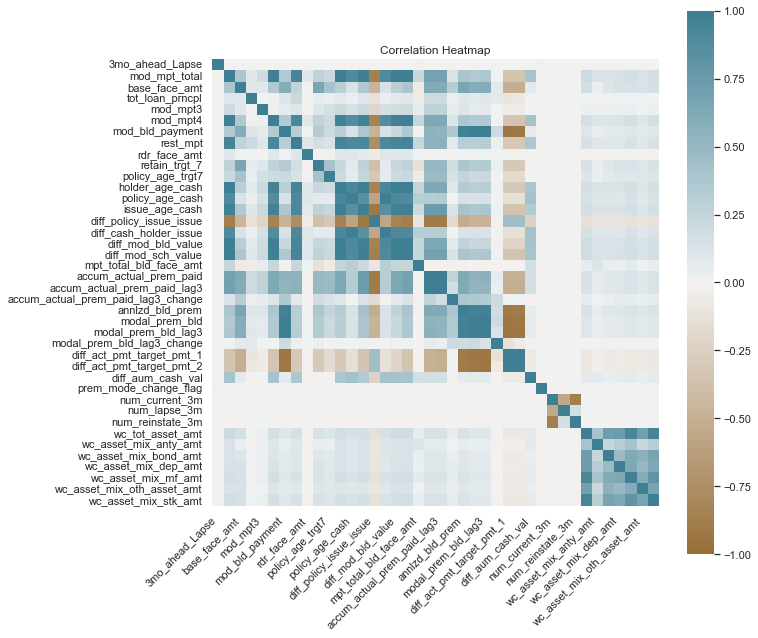

In [60]:
corr_df= df[df['3mo_ahead_Lapse']==1]
corr_plot(corr_df, '3mo_ahead_Lapse')

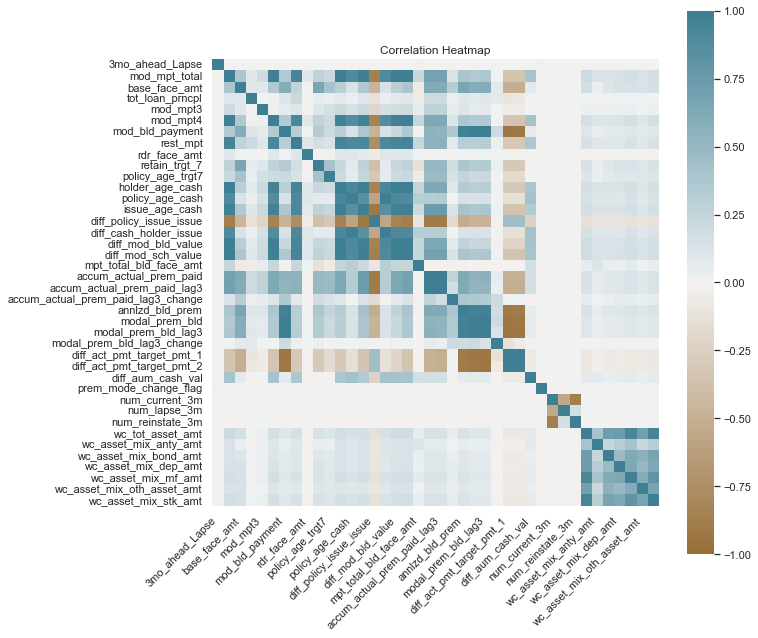

In [61]:
corr_df= df[df['3mo_ahead_Lapse']==0]
corr_plot(corr_df, '3mo_ahead_Lapse')

In [62]:
dgroup = df.groupby(["3mo_ahead_status"], as_index=True)[
        'holder_age',
        'policy_age',
        'base_face_amt',
        'mpt_tot_act_val',
        'mod_bld_payment',
        'annlzd_bld_prem',
        'subj_aum_amt',
        'diff_aum_cash_val',
        'diff_act_pmt_target_pmt_1',
        'diff_act_pmt_target_pmt_2',
        'diff_act_pmt_target_pmt_3',
        'diff_aum_cash_val',
        'prem_mode_change_flag',
        'num_current_3m',
        'num_lapse_3m',
        'num_reinstate_3m'
].mean()
dgroup= dgroup.round(2)
dgroup

,holder_age,policy_age,base_face_amt,mpt_tot_act_val,mod_bld_payment,annlzd_bld_prem,subj_aum_amt,diff_aum_cash_val,diff_act_pmt_target_pmt_1,diff_act_pmt_target_pmt_2,diff_act_pmt_target_pmt_3,diff_aum_cash_val,prem_mode_change_flag,num_current_3m,num_lapse_3m,num_reinstate_3m
3mo_ahead_status,,,,,,,,,,,,,,,,
current,53.79,275.83,173249.57,42348.01,1654.62,2732.51,4261325.81,4222063.42,-1140.87,-1139.77,356.45,4222063.42,0.00,3.00,0.0,0.00
lapse,41.75,91.07,322364.96,5387.84,2131.74,4205.04,17244.74,15508.22,-1623.56,-1589.19,598.94,15508.22,0.03,3.00,0.0,0.00
reinstated,56.14,242.09,150913.27,14245.21,1487.15,3737.18,29252.28,19370.62,-257.49,-257.49,1412.02,19370.62,0.02,2.99,0.0,0.01
surrender,54.47,321.11,111560.83,34647.87,704.96,1415.45,49650.06,20360.66,-355.30,-357.28,87.66,20360.66,0.01,3.00,0.0,0.00


In [63]:
dgroup = df.groupby(["current_status", "3mo_ahead_status"], as_index=True)[
        'mod_mpt_total',
        'tot_loan_prncpl',
        'mod_bld_payment',
        'diff_mod_bld_value',
        'mpt_total_bld_face_amt',
        'accum_actual_prem_paid_lag3_change', 
        'modal_prem_bld_lag3_change',
        'diff_act_pmt_target_pmt_1',
        'diff_act_pmt_target_pmt_2',
        'diff_aum_cash_val',
        'prem_mode_change_flag',
        'num_current_3m',
        'num_lapse_3m',
        'num_reinstate_3m'
].mean()
dgroup= dgroup.round(2)
dgroup

mod_mpt_total  tot_loan_prncpl  \
current_status 3mo_ahead_status                                   
current        current                39281.48          3066.77   
               lapse                   1738.81          3656.40   
               reinstated              9922.53          4385.81   
               surrender              29287.58          5360.29   
lapse          current                 6996.75             0.00   
reinstated     current                26723.96          6694.32   
               lapse                     88.00             0.00   
               reinstated              1872.00             0.00   
surrender      current                15671.84         17442.83   

                                 mod_bld_payment  diff_mod_bld_value  \
current_status 3mo_ahead_status                                        
current        current                   1654.63            37626.85   
               lapse                     2133.07             -394.26   
               reinstated                1491.98             8430.55   
               surrender                  704.96            28582.62   
lapse          current                    555.46             6441.29   
reinstated     current                    926.78            25797.17   
               lapse                     1181.00            -1093.00   
               reinstated                 540.00             1332.00   
surrender      current                   1055.26            14616.58   

                                 mpt_total_bld_face_amt  \
current_status 3mo_ahead_status                           
current        current                             0.34   
               lapse                               0.00   
               reinstated                          0.13   
               surrender                           0.31   
lapse          current                             0.07   
reinstated     current                             0.28   
               lapse                               0.00   
               reinstated                          0.02   
surrender      current                             0.19   

                                 accum_actual_prem_paid_lag3_change  \
current_status 3mo_ahead_status                                       
current        current                                       357.54   
               lapse                                         633.34   
               reinstated                                   1420.59   
               surrender                                      85.68   
lapse          current                                      1047.39   
reinstated     current                                       495.92   
               lapse                                         622.26   
               reinstated                                    357.11   
surrender      current                                         0.00   

                                 modal_prem_bld_lag3_change  \
current_status 3mo_ahead_status                               
current        current                                 1.10   
               lapse                                  34.47   
               reinstated                              0.00   
               surrender                              -1.98   
lapse          current                                 3.75   
reinstated     current                                 2.04   
               lapse                                   0.00   
               reinstated                              0.00   
surrender      current                                -1.52   

                                 diff_act_pmt_target_pmt_1  \
current_status 3mo_ahead_status                              
current        current                            -1140.90   
               lapse                              -1626.52   
               reinstated                          -258.09   
               surrender                           -355.30   
laps

#### Histogram

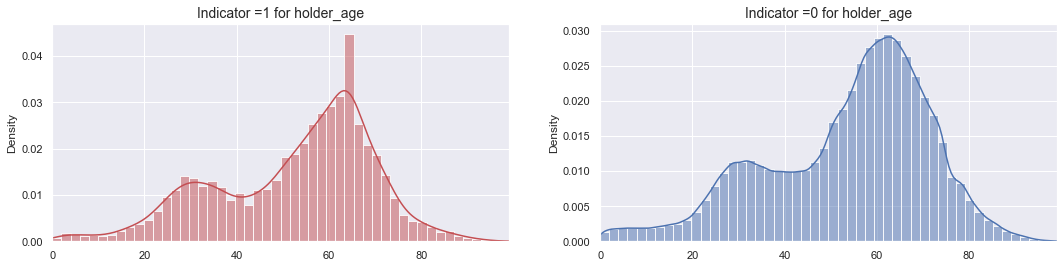

In [64]:
histplot('3mo_ahead_Lapse','holder_age')

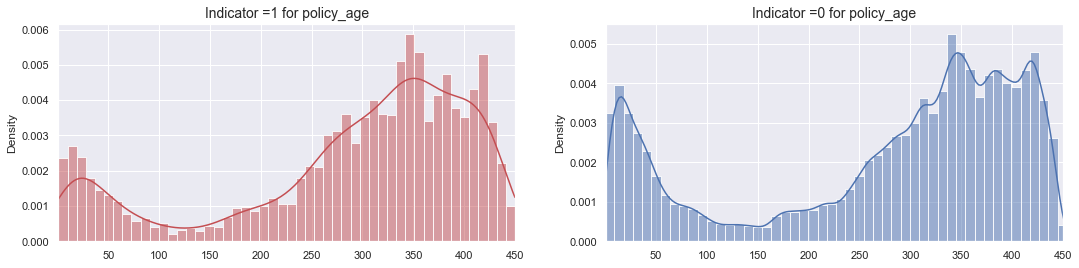

In [65]:
histplot('3mo_ahead_Lapse','policy_age')

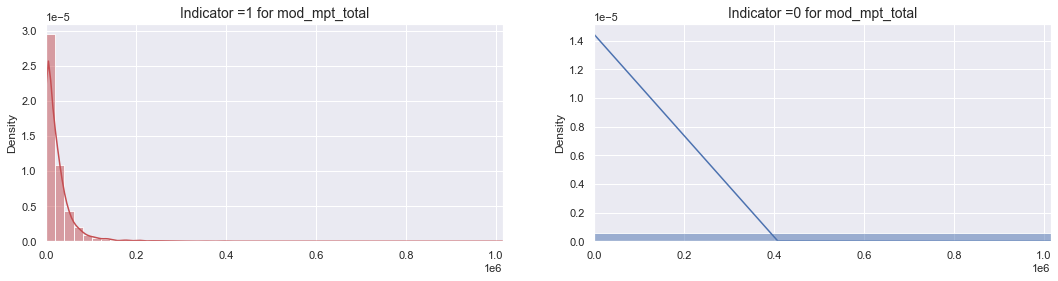

In [66]:
histplot('3mo_ahead_Lapse','mod_mpt_total')

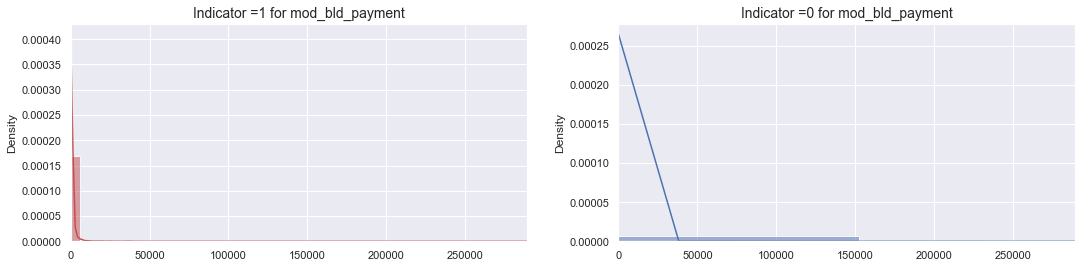

In [67]:
histplot('3mo_ahead_Lapse','mod_bld_payment')

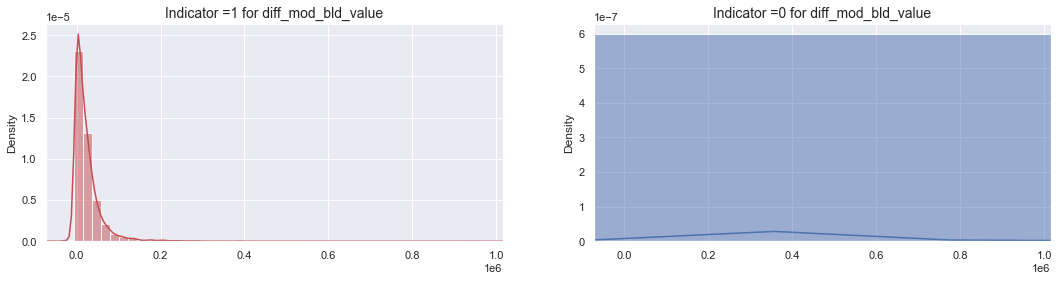

In [68]:
histplot('3mo_ahead_Lapse', 'diff_mod_bld_value')

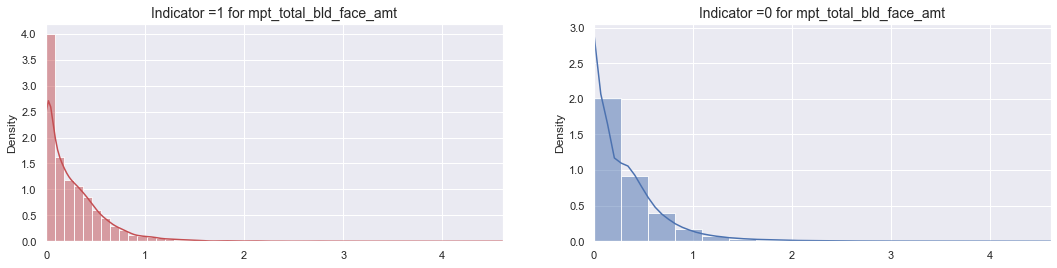

In [69]:
histplot('3mo_ahead_Lapse','mpt_total_bld_face_amt')

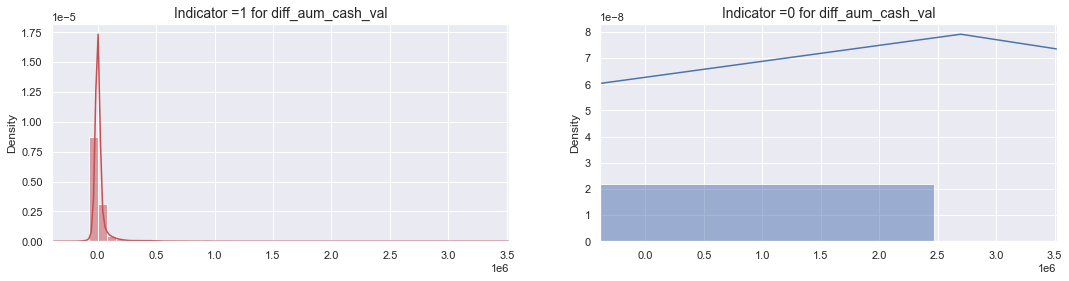

In [70]:
histplot('3mo_ahead_Lapse','diff_aum_cash_val')

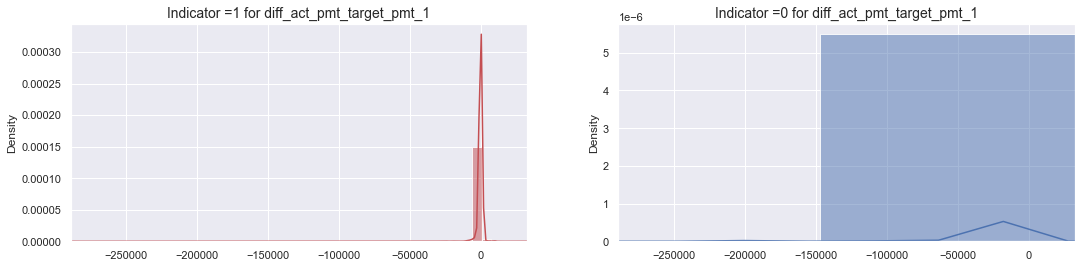

In [71]:
histplot('3mo_ahead_Lapse','diff_act_pmt_target_pmt_1')

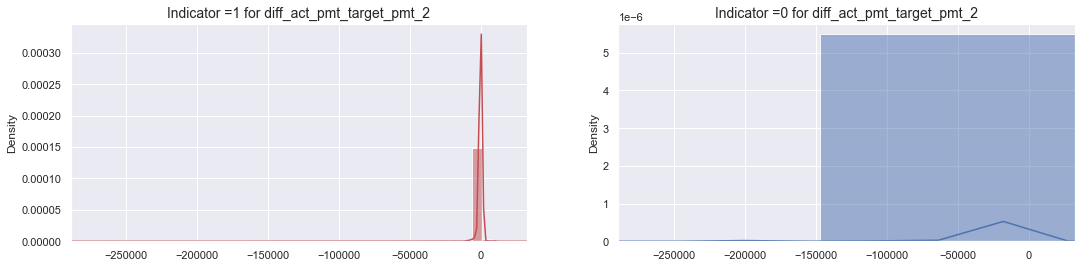

In [72]:
histplot('3mo_ahead_Lapse','diff_act_pmt_target_pmt_2')

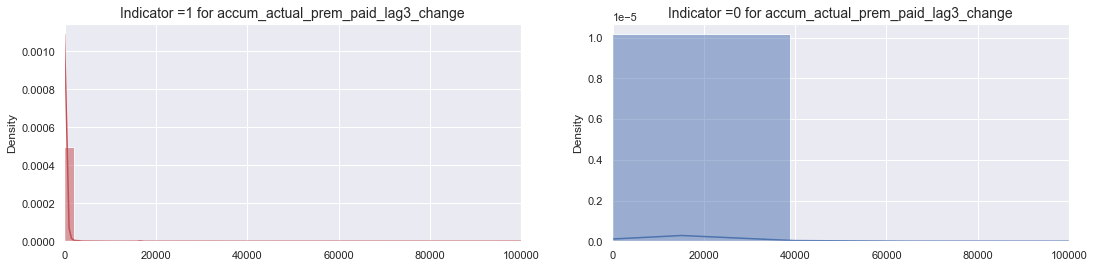

In [73]:
histplot('3mo_ahead_Lapse','accum_actual_prem_paid_lag3_change')

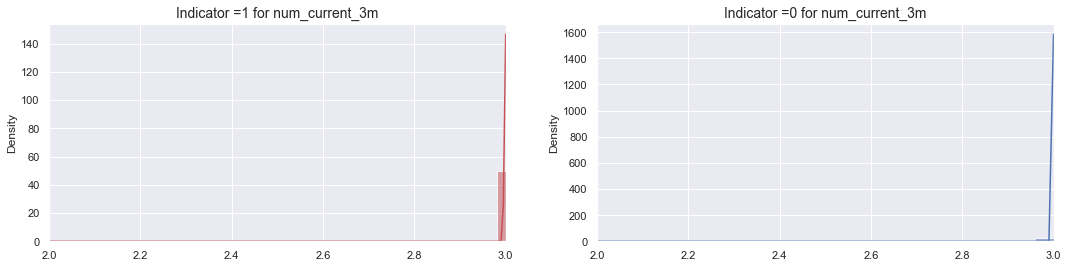

In [74]:
histplot('3mo_ahead_Lapse','num_current_3m')

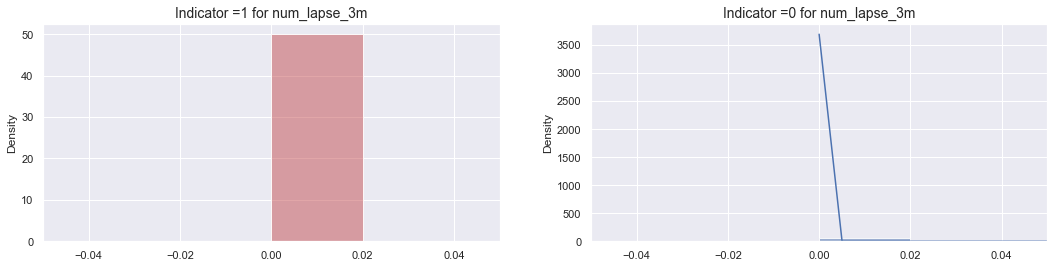

In [75]:
histplot('3mo_ahead_Lapse','num_lapse_3m')

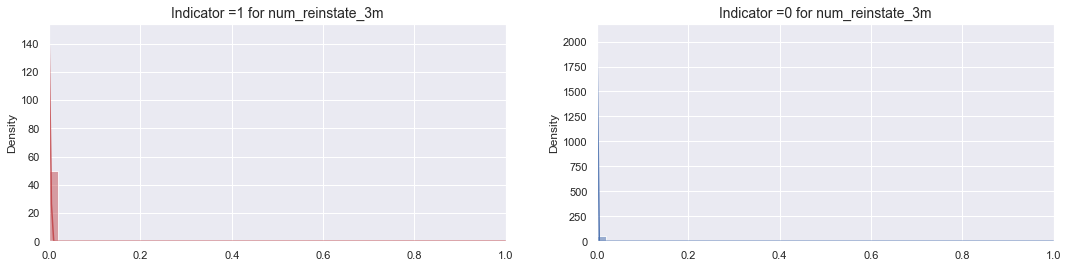

In [76]:
histplot('3mo_ahead_Lapse','num_reinstate_3m')

#### Cash value and payemnt trends

Text(0.5, 1.0, 'Modified Cash Value')

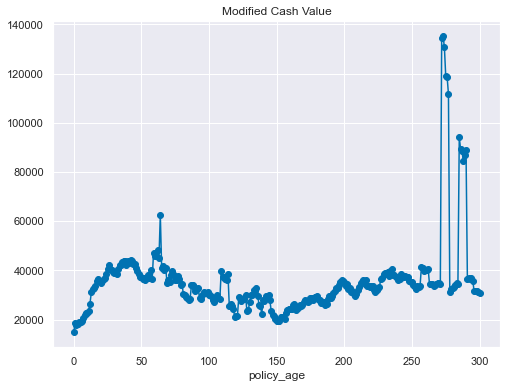

In [77]:
#p=df[df['policy_age']<=400]
df[df['policy_age']<=300].groupby(['policy_age'])['mod_mpt_total'].mean().plot(marker='o', figsize=(8,6))
plt.title('Modified Cash Value')

Text(0.5, 1.0, 'Cash Value by Lapse Indicator')

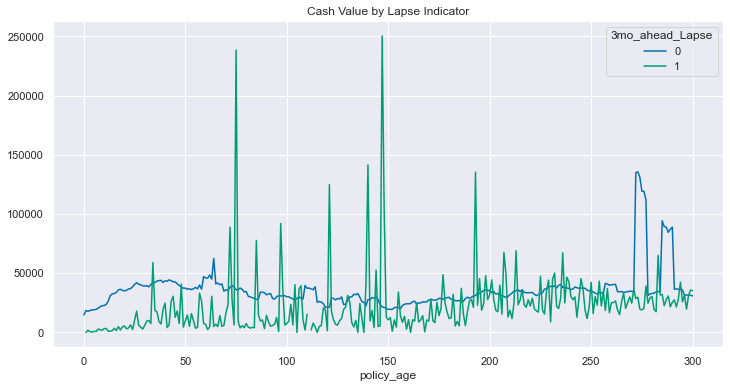

In [78]:
g = df[df['policy_age']<=300].groupby(['policy_age', '3mo_ahead_Lapse']).mod_mpt_total.mean()
ax=g.unstack().plot(figsize=(12, 6))
plt.title("Cash Value by Lapse Indicator")

Text(0.5, 1.0, 'Cash Value by Lapse Indicator')

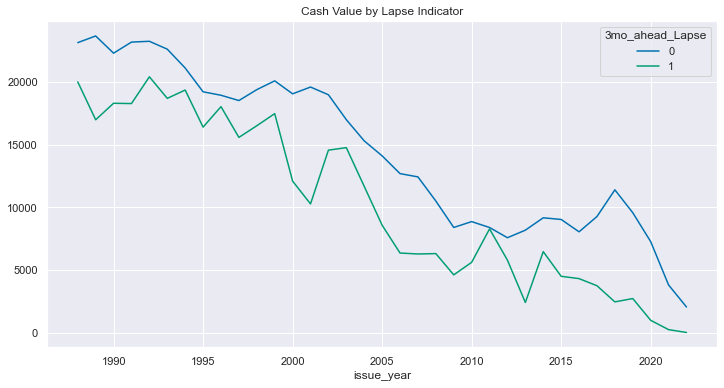

In [79]:
g = df[df['policy_age']<=400].groupby(['issue_year', '3mo_ahead_Lapse']).mod_mpt_total.median()
ax=g.unstack().plot(figsize=(12, 6))
plt.title("Cash Value by Lapse Indicator")

Text(0.5, 1.0, 'Billed Premium by Lapse Indicator')

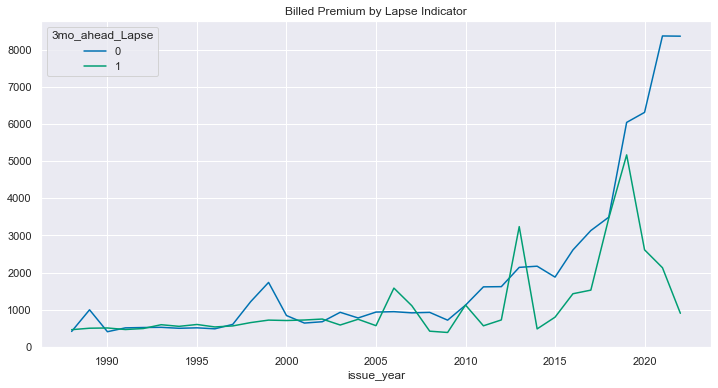

In [80]:
g = df[df['policy_age']<=400].groupby(['issue_year', '3mo_ahead_Lapse']).mod_bld_payment.mean()
ax=g.unstack().plot(figsize=(12, 6))
plt.title("Billed Premium by Lapse Indicator")

Text(0.5, 1.0, 'Diff: Cash Value and Premium to pay by Age Buckets')

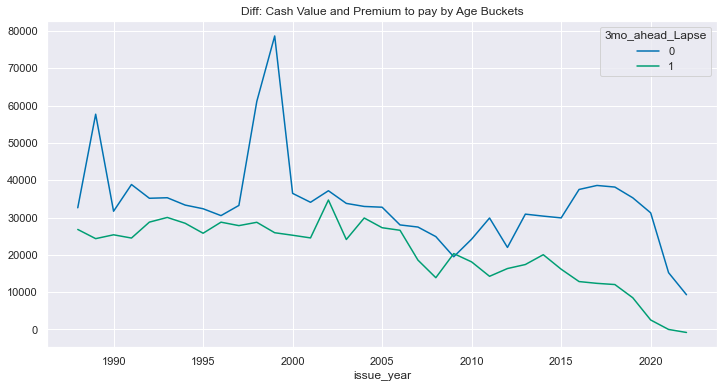

In [81]:
g = df[df['policy_age']<=400].groupby(['issue_year', '3mo_ahead_Lapse']).diff_mod_bld_value.mean()
ax=g.unstack().plot(figsize=(12, 6))
plt.title("Diff: Cash Value and Premium to pay by Age Buckets")

Text(0.5, 1.0, 'Cash Value normalized by Face Amt by Lapse Indicator')

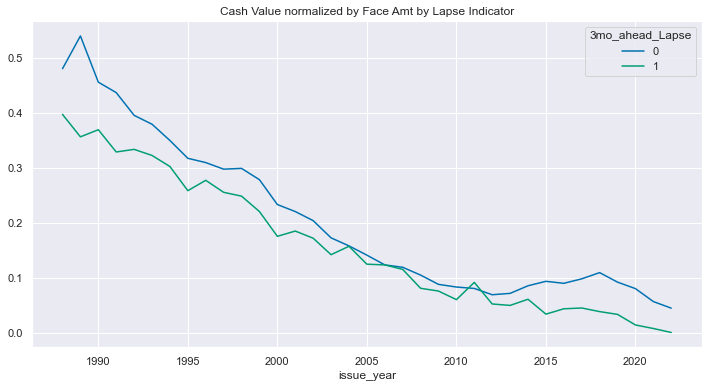

In [82]:
g = df[df['policy_age']<=400].groupby(['issue_year', '3mo_ahead_Lapse']).mpt_total_bld_face_amt.mean()
ax=g.unstack().plot(figsize=(12, 6))
plt.title("Cash Value normalized by Face Amt by Lapse Indicator")

Text(0.5, 1.0, 'Cash Value - Billed Payment by Lapse Indicator')

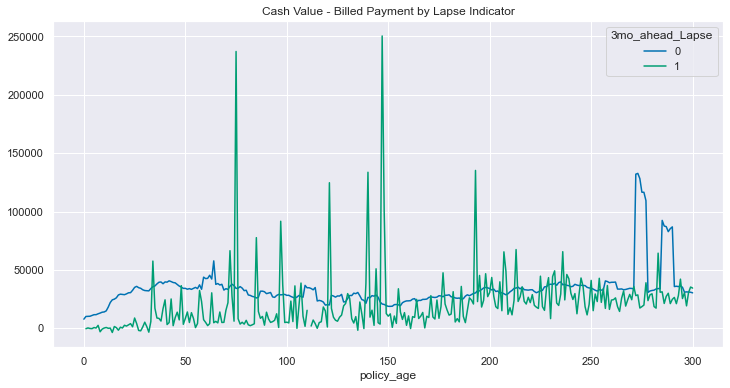

In [83]:
g = df[df['policy_age']<=300].groupby(['policy_age', '3mo_ahead_Lapse']).diff_mod_bld_value.mean()
ax=g.unstack().plot(figsize=(12, 6))
plt.title("Cash Value - Billed Payment by Lapse Indicator")

Text(0.5, 1.0, 'Billed Payment by Lapse Indicator')

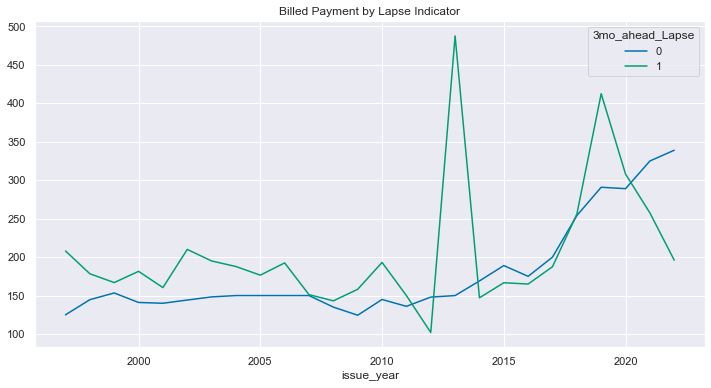

In [84]:
g = df[df['policy_age']<=300].groupby(['issue_year', '3mo_ahead_Lapse']).mod_bld_payment.median()
ax=g.unstack().plot(figsize=(12, 6))
plt.title("Billed Payment by Lapse Indicator")

<function matplotlib.pyplot.show(close=None, block=None)>

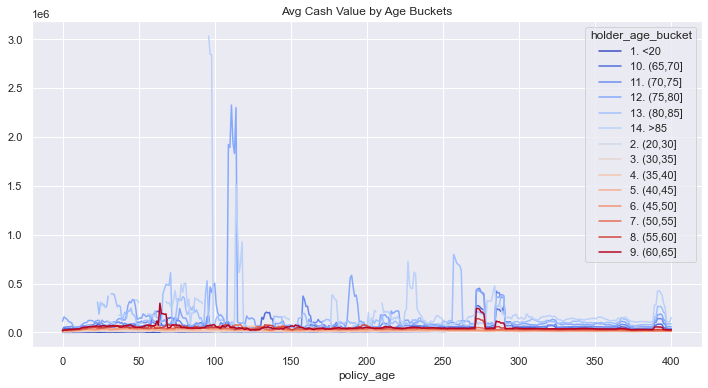

In [85]:
cmap = plt.cm.coolwarm
g = df[df['policy_age']<=400].groupby(['policy_age','holder_age_bucket']).mod_mpt_total.mean()
ax=g.unstack().plot(figsize=(12, 6), colormap=cmap)
plt.title("Avg Cash Value by Age Buckets")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

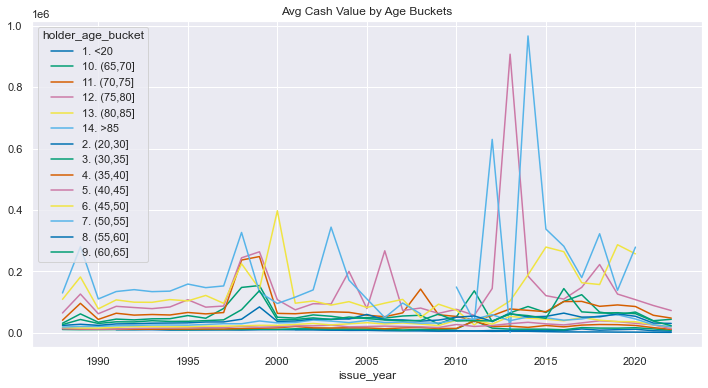

In [86]:
cmap = plt.cm.coolwarm
g = df[df['policy_age']<=400].groupby(['issue_year','holder_age_bucket']).mod_mpt_total.mean()
ax=g.unstack().plot(figsize=(12, 6))
plt.title("Avg Cash Value by Age Buckets")
plt.show

In [87]:
g1 = df.groupby(['policy_age','cash_val_bucket'])['3mo_ahead_Lapse'].sum()
g2 = df.groupby(['policy_age','cash_val_bucket'])['3mo_ahead_Lapse'].count()
g = pd.concat([g1, g2],axis=1)
g=g.reset_index()
#ax=g.unstack().plot(figsize=(12, 6))
g.columns = ['policy_age', 'cash_val_bucket', 'lapse_cnt', 'total_cnt']
g['monthly_lapsed_rate']=g['lapse_cnt']/g['total_cnt']
g['annual_lapsed_rate'] = (1- (1-g['monthly_lapsed_rate'])**12)*100
g

,policy_age,cash_val_bucket,lapse_cnt,total_cnt,monthly_lapsed_rate,annual_lapsed_rate
0,0,1. $0k-10k,0,1855,0.0,0.0
1,0,2. $10k-25k,0,358,0.0,0.0
2,0,3. $25k-50k,0,230,0.0,0.0
3,0,4. $50k-100k,0,118,0.0,0.0
4,0,5. $100k-250k,0,44,0.0,0.0
...,...,...,...,...,...,...
4342,453,3. $25k-50k,0,4,0.0,0.0
4343,453,4. $50k-100k,0,2,0.0,0.0
4344,453,5. $100k-250k,0,1,0.0,0.0
4345,454,2. $10k-25k,0,1,0.0,0.0


<AxesSubplot:xlabel='policy_age', ylabel='annual_lapsed_rate'>

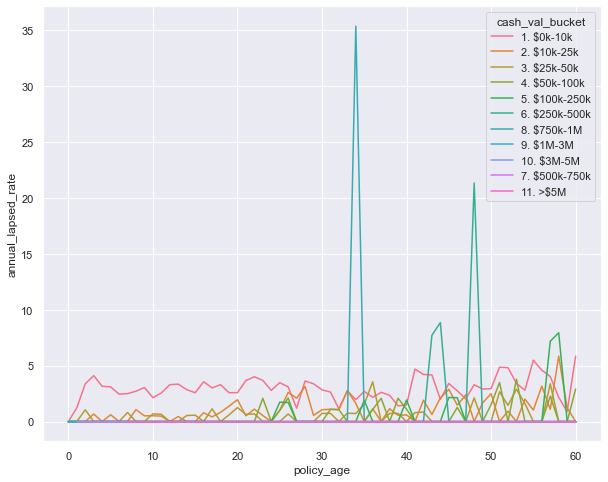

In [88]:
plt.figure(figsize=(10,8))
sns.lineplot(x='policy_age', y='annual_lapsed_rate', hue='cash_val_bucket', data=g[g['policy_age']<=60])

<AxesSubplot:xlabel='policy_age', ylabel='annual_lapsed_rate'>

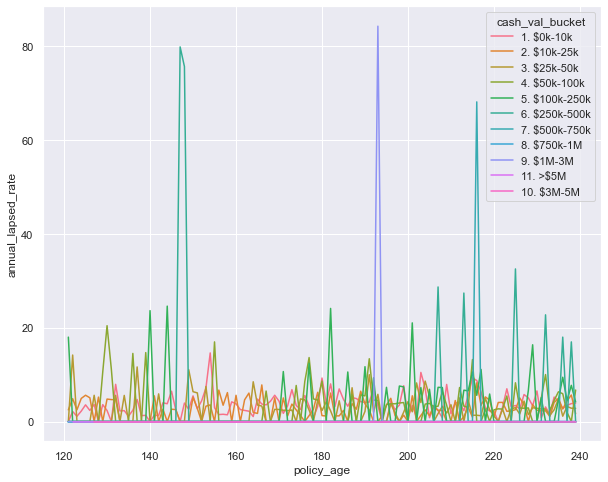

In [89]:
plt.figure(figsize=(10,8))
sample = g[(g['policy_age']>120) & (g['policy_age']<240)]
sns.lineplot(x='policy_age', y='annual_lapsed_rate', hue='cash_val_bucket', data=sample)

In [90]:
p = g.pivot(index='cash_val_bucket', columns='issue_yr', values='annual_lapsed_rate')
ax = p.T.plot(kind='bar', ylabel='Annual Lapse Rate')

KeyError: 'issue_yr'

In [ ]:
cmap = plt.cm.coolwarm
g = df[df['policy_age']<=400].groupby(['issue_year','cash_val_bucket']).diff_mod_bld_value.median()
ax=g.unstack().plot(figsize=(12, 6))
plt.title("Diff: Cash Value and Premium to pay by Age Buckets")
plt.show

In [ ]:
cmap = plt.cm.coolwarm
g = df[df['policy_age']<=400].groupby(['prem_mode','3mo_ahead_Lapse']).diff_mod_bld_value.mean()
ax=g.unstack().plot(figsize=(12, 6))
plt.title("Lapse by Prem Mode")
plt.show  #convert to percent

####  Lapse trend 


In [ ]:
def calc_ratio_cnt(seg, x, title): #count 
    g1 = df.groupby([x])['3mo_ahead_Lapse'].sum()
    g2 = df.groupby([x])['3mo_ahead_Lapse'].count()
    g = pd.concat([g1, g2],axis=1)
    g.columns = ['lapse_cnt', 'total_cnt']
    g['monthly_lapsed_rate']=g['lapse_cnt']/g['total_cnt']
    g['annual_lapsed_rate'] = (1- (1-g['monthly_lapsed_rate'])**12)*100
    
    g.plot(y='annual_lapsed_rate',figsize=(8,6))
    plt.title(title)
    plt.show

In [ ]:
def calc_ratio(seg, x, title): #count 
    g = seg.groupby([x])['lapsed_value','mod_mpt_total'].sum()  #base_face_amt, mod_mpt_total
    g['monthly_lapsed_ratio'] = g['lapsed_value']/g['mod_mpt_total']
    g['annual_lapsed_ratio'] = (1- (1-g['monthly_lapsed_ratio'])**12)*100
    
    g.plot(y='annual_lapsed_ratio',figsize=(8,6))
    plt.title(title)
    plt.show

In [ ]:
df['lapsed_value'] = np.where(df['3mo_ahead_Lapse']==1, df['mod_mpt_total'],0)

In [ ]:
# by time
calc_ratio_cnt(df, 'val_dt', 'Lapsed Rate by Time')

In [ ]:
calc_ratio_cnt(df, 'issue_year', 'Annualized Lapse Rate by Issue Year')

In [ ]:
calc_ratio_cnt(df, 'policy_age', 'Annualized Lapse Rate by Policy Age')

In [ ]:
calc_ratio(df, 'policy_age', 'Lapsed Ratio by Polciy Age')

In [ ]:
# age bucket
calc_ratio_cnt(df[df['holder_age_bucket']=='(40,45]'], 'policy_age', 'Lapsed Ratio, (40,45]')
calc_ratio_cnt(df[df['holder_age_bucket']=='(60,65]'], 'policy_age', 'Lapsed Ratio, (60,65]')
calc_ratio_cnt(df[df['holder_age_bucket']=='(65,70]'], 'policy_age', 'Lapsed Ratio, (65,70]')
calc_ratio_cnt(df[df['holder_age_bucket']=='(70,75]'], 'policy_age', 'Lapsed Ratio, (70,75]')

In [ ]:
# cash value bucket
calc_ratio(df[df['cash_val_bucket']== '$0k-50k'], 'issue_year', 'Lapsed Ratio, $0k-50k')
calc_ratio(df[df['cash_val_bucket']== '$50k-100k'], 'issue_year', 'Lapsed Ratio, $50k-100k')
calc_ratio(df[df['cash_val_bucket']== '$100k-250k'], 'issue_year', 'Lapsed Ratio, $100k-250k')
calc_ratio(df[df['cash_val_bucket']== '$250k-500k'], 'issue_year', 'Lapsed Ratio, $250k-500k')
calc_ratio(df[df['cash_val_bucket']== '$500k-750k'], 'issue_year', 'Lapsed Ratio, $500k-750k')
calc_ratio(df[df['cash_val_bucket']== '$750k-1M'], 'issue_year', 'Lapsed Ratio, $750k-1M')
calc_ratio(df[df['cash_val_bucket']== '$1M-3M'], 'issue_year', 'Lapsed Ratio, $1M-3M')

In [ ]:
# issue year
calc_ratio(df[df['issue_yr_cohort']== '< 1992'], 'issue_year', 'Lapsed Ratio, Issued before 1992')
calc_ratio(df[df['issue_yr_cohort']== '1992-2000'], 'issue_year', 'Lapsed Ratio, Issued 1992-2000')
calc_ratio(df[df['issue_yr_cohort']== '2001-2010'], 'issue_year', 'Lapsed Ratio, Issued 2001-2010')
calc_ratio(df[df['issue_yr_cohort']== '2011 to 2022'], 'issue_year', 'Lapsed Ratio, Issued 2011-Current')

In [ ]:
# 'mod_mpt_total',
# 'mod_mpt3',
# 'mod_mpt4',
# 'mod_bld_payment',
# 'diff_mod_bld_value',
# 'mpt_total_bld_face_amt',
# 'accum_actual_prem_paid',
# 'diff_act_pmt_target_pmt',
# 'accum_actual_prem_paid_lag3_change'

In [ ]:
def more_plots(x):
    f, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2)
    cmap = plt.cm.coolwarm
    sample_size = 2000000

    g = df[df['policy_age']<=400].sample(sample_size).groupby([x, '3mo_ahead_Lapse']).mod_mpt_total.median()
    g.unstack().plot(ax=ax1, figsize=(12, 8), colormap=cmap)
    ax1.set_title('Cash Value', fontsize=14)

    g = df[df['policy_age']<=400].sample(sample_size).groupby([x, '3mo_ahead_Lapse']).mod_bld_payment.median()
    g.unstack().plot(ax=ax2, figsize=(12, 8), colormap=cmap)
    ax2.set_title('Billed Payment', fontsize=14)

    g = df[df['policy_age']<=400].sample(sample_size).groupby([x, '3mo_ahead_Lapse']).diff_mod_bld_value.median()
    g.unstack().plot(ax=ax3, figsize=(12, 8), colormap=cmap)
    ax3.set_title('Difference between Cash Value and Billed Payment', fontsize=14)

    g = df[df['policy_age']<=400].sample(sample_size).groupby([x, '3mo_ahead_Lapse']).mpt_total_bld_face_amt.median()
    g.unstack().plot(ax=ax4, figsize=(12, 8), colormap=cmap)
    ax4.set_title('Cash Value divided by Face Amt', fontsize=14)

    g = df[df['policy_age']<=400].sample(sample_size).groupby([x, '3mo_ahead_Lapse']).accum_actual_prem_paid_lag3_change.median()
    g.unstack().plot(ax=ax5, figsize=(12, 8), colormap=cmap)
    ax5.set_title('Actual Premium Paid - 3month Window', fontsize=14)

    g = df[df['policy_age']<=400].sample(sample_size).groupby([x, '3mo_ahead_Lapse']).diff_act_pmt_target_pmt_2.median()
    g.unstack().plot(ax=ax6, figsize=(12, 8), colormap=cmap)
    ax6.set_title('Diff, Actual Prem vs. Target Prem', fontsize=14)

    plt.tight_layout()


In [ ]:
more_plots('issue_year')

In [ ]:
more_plots('policy_age')

### Categorical

In [ ]:
def freq_count(col):
    freq_df = df[col].value_counts(dropna=False, normalize=True).rename_axis(col).reset_index(name='percent')
    freq_df['percent']= freq_df['percent'].round(4)*100
    return freq_df

In [ ]:
def barplot(target, data, col):
    #plt.style.use('fivethirtyeight')
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 8))
    data1= data.loc[data[target]==1]
    data0= data.loc[data[target]==0]
    
    freq_df =pd.DataFrame(data1.groupby(col)[col].value_counts()).droplevel(1, axis=0).rename(columns={col: 'Percent'})
    freq_df1 =pd.DataFrame(data1.groupby(col)[col].value_counts()).droplevel(1, axis=0).rename(columns={col: 'Percent'})
    freq_df0 =pd.DataFrame(data0.groupby(col)[col].value_counts()).droplevel(1, axis=0).rename(columns={col: 'Percent'})
    
    pct_df = freq_df.divide(freq_df.sum(axis=0).sum()).sort_values('Percent',ascending=False).head(10)
    pct_df1 = freq_df1.divide(freq_df1.sum(axis=0).sum()).sort_values('Percent',ascending=False).head(10)
    pct_df0 = freq_df0.divide(freq_df0.sum(axis=0).sum()).sort_values('Percent',ascending=False).head(10)
    
    pct_df.plot(kind="barh",ax=ax1, stacked=True,title= (col + ' VUL Total'))
    pct_df1.plot(kind="barh",ax=ax2, stacked=True, title= (col + ' VUL Lapsed'))
    pct_df0.plot(kind="barh", ax=ax3, stacked=True, title= (col + ' VUL Non-Lapsed'))
    return plt.show()

In [ ]:
def multiple_barplot(target, col):
    fig, ax = plt.subplots(3,1, figsize=(18, 14))

    sns.barplot(x=col, y='diff_mod_bld_value', hue=target, data=df, ax=ax[0])
    ax[0].set_title('Diff: Cash Value - Billed Payment ' + col, fontsize=10)

    sns.barplot(x=col, y='diff_act_pmt_target_pmt_2', hue=target, data=df, ax=ax[1])
    ax[1].set_title('Diff: Actual - Target Payment ' + col, fontsize=10)

    sns.barplot(x=col, y='mpt_total_bld_face_amt', hue=target, data=df, ax=ax[2])
    ax[2].set_title('Cash value normalized by Face Amt' + col, fontsize=10)
    
    plt.show()

In [ ]:
def barplot_cnt(target, data, col):
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 8))
    data1= data.loc[data[target]==1]
    data0= data.loc[data[target]==0]
        
    data.groupby(col)[col].count().sort_values(ascending=False).head(10).plot(kind = 'barh', ax=ax1, title= (col + ' VUL Total'))
    data1.groupby(col)[col].count().sort_values(ascending=False).head(10).plot(kind = 'barh', ax=ax2, title= (col + ' VUL Lapsed'))
    data0.groupby(col)[col].count().sort_values(ascending=False).head(10).plot(kind = 'barh', ax=ax3, title= (col + ' VUL Non-Lapsed'))
    return plt.show()

In [ ]:
def cross_tab_barplot(col1, col2):
    fig, ax = plt.subplots(2,1, figsize=(14, 12))
    df1 = df[df['3mo_ahead_Lapse']==1]
    ct = pd.crosstab(df1[col1],df1[col2], normalize='index').round(4)*100
    stacked = ct.stack().reset_index().rename(columns={0:'Percent'})
    sns.barplot(x=stacked[col1], y=stacked.Percent, hue=stacked[col2], ax=ax[0])
    ax[0].set_title("VUL Lapsed by " + col1 + '-' + col2 )

    df0 = df[df['3mo_ahead_Lapse']==0]
    ct = pd.crosstab(df0[col1],df0[col2], normalize='index').round(4)*100
    stacked = ct.stack().reset_index().rename(columns={0:'Percent'})
    sns.barplot(x=stacked[col1], y=stacked.Percent, hue=stacked[col2], ax=ax[1])
    ax[1].set_title("VUL Non-Lapsed by " + col1 + '-' + col2 )
    return plt.show()

In [ ]:
# Policy holder age
barplot('3mo_ahead_Lapse', df, 'holder_age_bucket') 

In [ ]:
multiple_barplot('3mo_ahead_Lapse', 'holder_age_bucket')

In [ ]:
cross_tab_barplot('gndr_cd', 'holder_age_bucket')

In [ ]:
barplot('3mo_ahead_Lapse', df, 'cash_val_bucket')

In [ ]:
multiple_barplot('3mo_ahead_Lapse', 'cash_val_bucket')

In [ ]:
cross_tab_barplot('holder_age_bucket', 'cash_val_bucket')

In [ ]:
cross_tab_barplot('cash_val_bucket', 'issue_yr_cohort') # prior 1992/after 1992

In [ ]:
cross_tab_barplot('issue_yr_cohort', 'holder_age_bucket')

In [ ]:
cross_tab_barplot('prem_mode_lag1', 'prem_mode')

In [ ]:
barplot('3mo_ahead_Lapse',df, 'iss_prem_mode')

In [ ]:
barplot('3mo_ahead_Lapse',df, 'smoking_habit')

In [ ]:
cross_tab_barplot('smoking_habit', 'holder_age_bucket')

In [ ]:
cross_tab_barplot('holder_age_bucket', 'cash_val_bucket')

In [ ]:
barplot('3mo_ahead_Lapse', df, 'prem_mode_change_flag')

In [ ]:
cross_tab_barplot('holder_age_bucket', 'prem_mode_change_flag')

In [ ]:
cross_tab_barplot('cash_val_bucket', 'prem_mode_change_flag')

In [ ]:
barplot('3mo_ahead_Lapse', df, 'num_current_3m')

In [ ]:
barplot('3mo_ahead_Lapse', df, 'val_inforce_cls')

In [ ]:
barplot('3mo_ahead_Lapse', df, 'prod_grp')

In [ ]:
barplot('3mo_ahead_Lapse', df, 'mrtl_stat_cd')

In [ ]:
barplot('3mo_ahead_Lapse', df, 'occ_rating')

In [ ]:
barplot('3mo_ahead_Lapse', df, 'prem_mode')

In [ ]:
barplot('3mo_ahead_Lapse', df, 'abbr_pay_typ_cd')

In [ ]:
barplot('3mo_ahead_Lapse', df, 'place_abbrev')

In [ ]:
barplot('3mo_ahead_Lapse', df, 'rtl_dstrb_orphn_cd')

In [ ]:
barplot('3mo_ahead_Lapse', df, 'aos_status_code')

In [ ]:
cross_tab_barplot('rtl_dstrb_orphn_cd', 'holder_age_bucket')

In [ ]:
cross_tab_barplot('num_current_3m', 'num_reinstate_3m')

### segment analysis

In [ ]:
dgroup = df.groupby(["holder_age_bucket", "3mo_ahead_Lapse"], as_index=True)[  'mod_mpt_total',
        'mod_bld_payment',
        'diff_mod_bld_value',
        'mpt_total_bld_face_amt',
        'accum_actual_prem_paid',
        'diff_act_pmt_target_pmt_1',
        'diff_act_pmt_target_pmt_2',
        'diff_aum_cash_val'].mean()

dgroup2 = df.groupby(["holder_age_bucket", "3mo_ahead_Lapse"], as_index=True)['3mo_ahead_Lapse'].sum()
dgroup3= (dgroup2 / dgroup2.groupby(level=[1]).transform("sum")).round(4)*100
g = pd.concat([dgroup2, dgroup3, dgroup],axis=1)
g

In [ ]:
dgroup = df.groupby(["issue_yr_cohort", "3mo_ahead_Lapse"], as_index=True)[  
        'mod_mpt_total',
        'mod_bld_payment',
        'diff_mod_bld_value',
        'mpt_total_bld_face_amt',
        'accum_actual_prem_paid',
        'diff_act_pmt_target_pmt_1',
        'diff_act_pmt_target_pmt_2',
        'diff_act_pmt_target_pmt_3',
        'diff_aum_cash_val'].mean()

dgroup2 = df.groupby(["issue_yr_cohort", "3mo_ahead_Lapse"], as_index=True)['3mo_ahead_Lapse'].sum()
dgroup3= (dgroup2 / dgroup2.groupby(level=[1]).transform("sum")).round(4)*100
g = pd.concat([dgroup2, dgroup3, dgroup],axis=1)
g

In [ ]:
dgroup = df.groupby(["prem_mode_change_flag", "3mo_ahead_Lapse"], as_index=True)[  'mod_mpt_total',
        'mod_bld_payment',
        'diff_mod_bld_value',
        'mpt_total_bld_face_amt',
        'accum_actual_prem_paid',
        'diff_act_pmt_target_pmt_1',
        'diff_act_pmt_target_pmt_2',
        'diff_aum_cash_val'
].mean()

dgroup2 = df.groupby(["prem_mode_change_flag", "3mo_ahead_Lapse"], as_index=True)['3mo_ahead_Lapse'].sum()
dgroup3= (dgroup2 / dgroup2.groupby(level=[1]).transform("sum")).round(4)*100
g = pd.concat([dgroup2, dgroup3, dgroup],axis=1)
g

In [ ]:
dgroup = df.groupby(["prem_mode", "3mo_ahead_Lapse"], as_index=True)[ 'mod_mpt_total',
        'mod_bld_payment',
        'diff_mod_bld_value',
        'mpt_total_bld_face_amt',
        'accum_actual_prem_paid',
        'diff_act_pmt_target_pmt_1',
        'diff_act_pmt_target_pmt_2',
        'diff_aum_cash_val'].mean()

dgroup2 = df.groupby(["prem_mode", "3mo_ahead_Lapse"], as_index=True)['3mo_ahead_Lapse'].sum()
dgroup3= (dgroup2 / dgroup2.groupby(level=[1]).transform("sum")).round(4)*100
g = pd.concat([dgroup2, dgroup3, dgroup],axis=1)
g

#### scatter plots, more granular

In [ ]:
temp = df.sample(1000000)
temp['monthly_lapsed_rate'] = temp['lapsed_value']/temp['base_face_amt']

plt.figure(figsize=(10,6))
plt.title('Difference b/w Cash Value and Billed Premimum ')
sns.scatterplot(x='diff_mod_bld_value',y='monthly_lapsed_rate',data=temp,hue='cash_val_bucket',
                palette='coolwarm')

In [ ]:
temp = df[(df['holder_age_bucket']=='(60,65]')]
temp['monthly_lapsed_rate'] = temp['lapsed_value']/temp['base_face_amt']

plt.figure(figsize=(10,6))
plt.title('Difference b/w Cash Value and Billed Premimum: Age (60-65] ')
sns.scatterplot(x='diff_mod_bld_value',y='monthly_lapsed_rate',data=temp,hue='cash_val_bucket',
                palette='coolwarm')

### S-Curve type

#### choose columns to export 

In [ ]:
pd.set_option('display.max_rows', None) 
df.agg(['count', 'nunique', 'min', 'max']).transpose()

#### export to parquet file 

In [ ]:
#df_export = df[['agmt_pkge_id', ]]

In [55]:
# df.to_parquet('lapse_data_jan_june.parquet')